## Setup

In [175]:
import pandas as pd
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx

In [176]:
import sys, os
sys.path.append('../../gnumap/')
from models.train_models import *
from scipy import optimize

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from codecarbon import OfflineEmissionsTracker
from umap_functions import *
from simulation_utils import make_roll

In [177]:
make_roll

<function simulation_utils.make_roll(c=0.6, v=4, omega=12, n_samples=2000, n_neighbours=30, a=2, b=2, scale=0.5, plot=True, features=None, standardize=True)>

In [178]:
N_NEIGHBOURS = 5

## Data generation

In [5]:
import random
random.seed(12345)
X, t, new_data, u = make_roll(n_neighbours = N_NEIGHBOURS, a = 1, b = 1, scale=0.1, n_samples = 4000)
# new_data is graph object

(array([3.4860e+03, 1.0972e+04, 6.4200e+03, 2.2160e+03, 6.6400e+02,
        2.1000e+02, 6.4000e+01, 1.8000e+01, 0.0000e+00, 2.0000e+00]),
 array([0.00811681, 0.10730513, 0.20649345, 0.30568177, 0.40487009,
        0.50405841, 0.60324673, 0.70243504, 0.80162336, 0.90081168,
        1.        ]),
 <BarContainer object of 10 artists>)

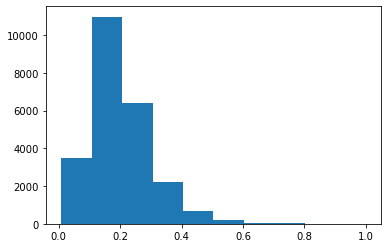

In [6]:
plt.hist(new_data.edge_weight)

In [7]:
x = X[:,0]
y = X[:,1]
z = X[:,2]

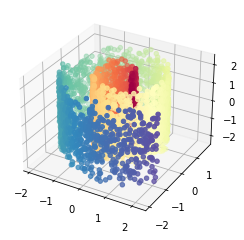

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=t, cmap='Spectral')

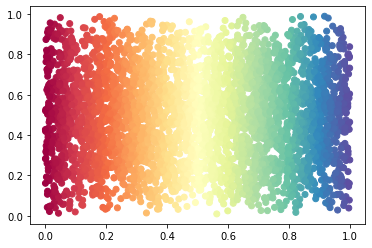

In [9]:
perfect_embeddings = np.zeros((4000,2))
perfect_embeddings[:,0] = t
perfect_embeddings[:,1] = u
plt.scatter(t,u, c = t , cmap ='Spectral')

In [10]:
# import umap.umap_ as umap
import umap
import numpy as np
from sklearn.neighbors import kneighbors_graph

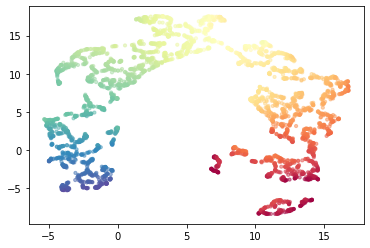

In [11]:
X = np.vstack([np.array(x),np.array(y),np.array(z)]).T
A_dist = kneighbors_graph(X, N_NEIGHBOURS, mode='distance', include_self=False)
umap_embedding = umap.UMAP(n_components=2, n_neighbors= 10, min_dist= 0.1).fit_transform(X)
plt.scatter(*umap_embedding.T, s=10, c=t, alpha=0.5, cmap='Spectral')

In [12]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, umap_embedding, n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, umap_embedding, n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.6647)

0.6418086585833799

The number of neighbor regulates how much local information that you want to reflect on the embedding spcaces. The smaller the local n_neighbor, the more local your embedding is. 

not so well for the "real" graph data

## Draw reconstructed graph

<Figure size 432x288 with 0 Axes>

/var/folders/52/dh42902j7rv__r8tnhmqf8_w0000gn/T/ipykernel_35382/367358442.py:4: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),


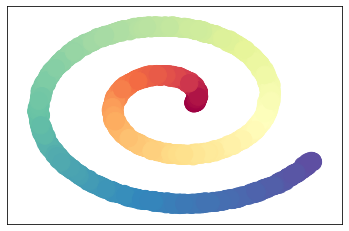

In [13]:
# A_dist = kneighbors_graph(X, 5, mode='distance', include_self=False)
### Very sensitive to wrong edges
plt.figure()
nx.draw_networkx(nx.from_scipy_sparse_matrix(A_dist),
                 pos={i:[new_data.x[i,0].numpy(),new_data.x[i,1].numpy()] for i in range(new_data.num_nodes)},
                 # to see the "roll" it should by x, y axis
                 node_color=t, cmap='Spectral', with_labels=False)
plt.show()

n_neighbors = 3 : small k puts more emphasis on the local structure

# Define GNUMAP model

In [14]:
from models.data_augmentation import *

In [15]:
import numpy as np
from carbontracker.tracker import CarbonTracker
import cProfile
import os
import scipy
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, negative_sampling
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix
from torch_geometric.transforms import NormalizeFeatures
import time
from umap_functions import *
from graph_utils import *
from models.data_augmentation import *
import matplotlib.pyplot as plt
from models.baseline_models import *

In [16]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)
    
"""
Understanding Contrastive Representation Learning through
Alignment and Uniformity on the Hypersphere

source: https://arxiv.org/pdf/2005.10242.pdf

alignment and uniformity regularizations
"""

def uniform_loss(x, t=2):
    return torch.pdist(x,p=2).pow(2).mul(-t).exp().mean().log()
    # return torch.log(torch.mean(-t*(torch.pdist(x,p=2)**2)))
    # rewrite with torch command
def align_loss(x,y, theta = 2):
    return torch.norm(x-y, dim = 1).pow(theta).mean()


'\nUnderstanding Contrastive Representation Learning through\nAlignment and Uniformity on the Hypersphere\n\nsource: https://arxiv.org/pdf/2005.10242.pdf\n\nalignment and uniformity regularizations\n'

In [53]:
from diffusion_map_np import *
diff_embeddings = apply_diffusions(X, alpha = 1.0, n_eign = 2, n_diff = 5, epsilon = 50)
diff_embeddings = torch.tensor(diff_embeddings, dtype=torch.float32)

SyntaxError: invalid syntax (1490005688.py, line 2)

In [67]:
diff_weight = torch.exp(
    -(torch.sum(torch.square(diff_embeddings[new_data.edge_index[0]]-diff_embeddings[new_data.edge_index[1]])-1e-16, dim = 1))/1e-12
)

In [68]:
diff_weight

tensor([0.4587, 0.5203, 0.0041,  ..., 0.4693, 0.5141, 1.0001])

(array([3.4860e+03, 1.0972e+04, 6.4200e+03, 2.2160e+03, 6.6400e+02,
        2.1000e+02, 6.4000e+01, 1.8000e+01, 0.0000e+00, 2.0000e+00]),
 array([0.00811681, 0.10730513, 0.20649345, 0.30568177, 0.40487009,
        0.50405841, 0.60324673, 0.70243504, 0.80162336, 0.90081168,
        1.        ]),
 <BarContainer object of 10 artists>)

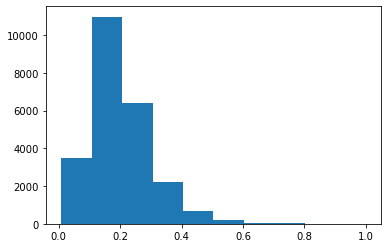

In [71]:
plt.hist(new_data.edge_weight)

(array([5742., 1408., 1168., 1000., 1132., 1160., 1366., 1724., 2192.,
        7160.]),
 array([7.1848286e-26, 1.0002001e-01, 2.0004001e-01, 3.0006000e-01,
        4.0008003e-01, 5.0010002e-01, 6.0012001e-01, 7.0014000e-01,
        8.0016005e-01, 9.0018004e-01, 1.0002000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

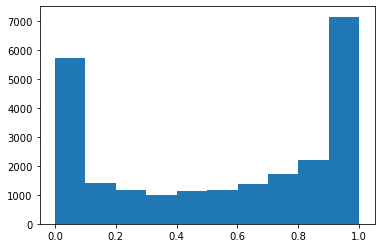

In [69]:
plt.hist(diff_weight)

In [134]:
torch.sum(deg(new_data.edge_index))/new_data.num_nodes

tensor(6.0130)

In [72]:
diff_data = Data(x=new_data.x, edge_index=new_data.edge_index, # if feature drops the feature matrix should be updated
                y=new_data.y, edge_weight=diff_weight,
                transform = NormalizeFeatures)

In [74]:
def train_gnumap(data, hid_dim, dim, n_layers=2, dropout_rate = 0.5, target=None,
                 model_type = 'GCN', must_propagate=None, norm = 'normalize',
                 patience=20, epochs=200, lr=1e-3, wd=1e-2,
                 min_dist=0.1, name_file="1", subsampling=None,
                 spread = 1.0, repulsion_strength=None,
                 device=None, verbose = False, normalized = True):


    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   # EPS_0 = data.num_edges/ (data.num_nodes ** 2)
    _a, _b = find_ab_params(spread, min_dist) # spread , min_dist given as hyperparameter

    if torch_geometric.utils.is_undirected(data.edge_index):
        new_edge_index, new_edge_attr = data.edge_index, data.edge_weight
    else:
        new_edge_index, new_edge_attr = torch_geometric.utils.to_undirected(data.edge_index, data.edge_weight)

    
    #### Prune
    EPS = 1e-20 #math.exp(-1.0/(2*_b) * math.log(1.0/_a * (1.0/EPS_0 -1)))
    # print("Epsilon is " + str(EPS))
    print("Hyperparameters a = " + str(_a) + " and b = " + str(_b))

    if model_type == 'GNN':
        model = GNN(data.num_features, hid_dim, dim, n_layers=n_layers,
                    must_propagate=must_propagate, norm=norm)
    elif model_type == 'GCN':
        model = GCN(data.num_features, hid_dim, dim, n_layers = n_layers,dropout_rate = dropout_rate)
    elif model_type == 'MLP':
        model = MLP(data.num_features, hid_dim, dim)
    model = model.to(device)
    model.apply(init_weights)
    new_data = Data(x=data.x, edge_index=new_edge_index, # if feature drops the feature matrix should be updated
                    y=data.y, edge_weight=new_edge_attr,
                    transform = NormalizeFeatures)

    #optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay= wd)
    optimizer = torch.optim.Adam(model.parameters(),lr = lr)
    new_data = new_data.to(device)
    sparsity =  new_data.num_edges/(new_data.num_nodes**2 -new_data.num_nodes)
    
    if repulsion_strength is None:
        repulsion_strength = 1.0/sparsity
        # we have way more samples that are "not" connected(sparsity), so need to give more weight to negative sampling to get balanced results
    row_pos, col_pos =  new_data.edge_index
    index = (row_pos != col_pos)
        # to exclude self-connectivity
    edge_weights_pos = new_data.edge_weight#[index]
    edge_weights_pos = torch.clip(edge_weights_pos, min=EPS, max = 1)

    if target is not None:
        edge_weights_pos = fast_intersection(row_pos[index], col_pos[index], edge_weights_pos,
                                             target, unknown_dist=1.0, far_dist=5.0)
        # p_{ij}
    if subsampling is None:
        row_neg, col_neg = negative_sampling(new_data.edge_index, num_neg_samples = 5 * new_data.edge_index.shape[1] )
        # negative_sample_rate: int (optional, default 5), the number of negative samples to select per positive sample
        index_neg = (row_neg != col_neg)
        edge_weights_neg = EPS * torch.ones(len(row_neg))
        if target is not None:
            edge_weights_neg = fast_intersection(row_neg[index_neg], col_neg[index_neg], edge_weights_neg,
                                                 target, unknown_dist=1.0, far_dist=5.0)
    best_t=0
    cnt_wait = 0
    best=1e9
    log_sigmoid = torch.nn.LogSigmoid()
    edges = [(e[0],e[1]) for _, e in enumerate(data.edge_index.numpy().T)]
    loss_vals = []
    CE = nn.BCELoss()
    for epoch in range(epochs):
        tic_epoch = time.time()
        model.train()
        optimizer.zero_grad()
        tic = time.time()
        out = model(new_data.x.float(), new_data.edge_index) # data.edge_index?
        # if normalized is True:
        #    out = F.normalize(out) # add normalization**
        diff_norm = torch.sum(torch.square(out[row_pos[index]] - out[col_pos[index]]), 1)
        diff_norm = torch.clip(diff_norm, min=1e-3)
        log_q = - torch.log1p(_a *  diff_norm ** _b) # 1/(1+a*d^2b)
        loss_pos = -torch.mean(
             edge_weights_pos[index]*log_sigmoid(log_q)
             + (1- edge_weights_pos[index])*(log_sigmoid(log_q)-log_q)*repulsion_strength
         )  

        if subsampling is None:
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
        else:
            row_neg, col_neg = negative_sampling(new_data.edge_index,
                                                 num_neg_samples=subsampling, force_undirected = True)
            index_neg = (row_neg != col_neg)
            edge_weights_neg = EPS * torch.ones(len(row_neg))
            if target is not None:
                edge_weights_neg = fast_intersection(row_neg[index_neg],
                                                     col_neg[index_neg], edge_weights_neg,
                                                     target, unknown_dist=1.0, far_dist=5.0)
            diff_norm_neg = torch.sum(torch.square(out[row_neg[index_neg]] - out[col_neg[index_neg]]), 1) #+ 1e-3
            diff_norm_neg = torch.clip(diff_norm_neg, min=1e-3)
            log_q_neg = - torch.log1p(_a *  diff_norm_neg ** _b)
     
        loss_neg = - torch.mean((log_sigmoid(log_q_neg) - log_q_neg ) * repulsion_strength)
        ### Add a term to make sure that the features are learned independently
        # loss_unif = uniform_loss(out, t = 2)
        loss =  loss_pos + loss_neg  #+ loss_unif
        if verbose is True:
            print("loss neg", loss_neg)
            print("loss poss", loss_pos)
            print("loss final", loss)
        tic =  time.time()
        loss.backward()
        optimizer.step()
        loss_vals.append(loss.detach().numpy())
        #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=4)



        if verbose is True:
            if epoch%10== 0:
                u = out.detach().numpy()
                plt.figure()
                plt.scatter(u[:,0], u[:,1], c = t,
                            cmap="Spectral")
                plt.show()
                print(torch.mm(out.T, out)/ new_data.num_nodes)

        for g in optimizer.param_groups:
            g['lr'] = lr * (1.0 - (float(epoch) / float(epochs)))

        print('Epoch={:03d}, loss={:.4f}, time={:.4f}'.format(epoch, loss.item(),time.time()-tic_epoch))
        if loss < best:
            best = loss
            best_t = epoch
            cnt_wait = 0
            torch.save(model.state_dict(), os.getcwd()  + '/results/best_gnumap_'
                                          + '_dim' + str(dim) + '_' + name_file +  '.pkl')
        else:
            cnt_wait += 1
        if cnt_wait == patience and epoch>200:
            print('Early stopping at epoch {}!'.format(epoch))
            break
        #print("Time epoch after saving", time.time()-tic_epoch)
    #tracker.stop()
    print('Loading {}th epoch'.format(best_t))
    model.load_state_dict(torch.load(os.getcwd()  + '/results/best_gnumap_' +
                                     '_dim' + str(dim) + '_' + name_file + '.pkl'))
    return(model,new_edge_index, loss_vals)

## Run simplest model

### GCN-layer 2

In [18]:
cd /Users/sowonjeong/Documents/GitHub/gnumap/notebooks

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks


/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=1.6948, time=0.0491
Epoch=001, loss=1.3978, time=0.0356
Epoch=002, loss=1.1520, time=0.0385
Epoch=003, loss=1.0161, time=0.0381
Epoch=004, loss=0.9792, time=0.0405
Epoch=005, loss=0.9587, time=0.0433
Epoch=006, loss=0.9482, time=0.0363
Epoch=007, loss=0.9538, time=0.0372
Epoch=008, loss=0.9505, time=0.0356
Epoch=009, loss=0.9394, time=0.0340
Epoch=010, loss=0.9318, time=0.0436
Epoch=011, loss=0.9283, time=0.0444
Epoch=012, loss=0.9251, time=0.0386
Epoch=013, loss=0.9217, time=0.0404
Epoch=014, loss=0.9194, time=0.0702
Epoch=015, loss=0.9227, time=0.0530
Epoch=016, loss=0.9138, time=0.0455
Epoch=017, loss=0.9146, time=0.0391
Epoch=018, loss=0.9134, time=0.0354
Epoch=019, loss=0.9087, time=0.0363
Epoch=020, loss=0.9063, time=0.0398
Epoch=021, loss=0.9119, time=0.0548
Epoch=022, loss=0.9072, time=0.0432
Epoch=023, loss=0.9073, time=0.0426
Epoch=024, loss=0.9048, time=0.0494
Epoch=025, loss=0.9030, time=0.0440

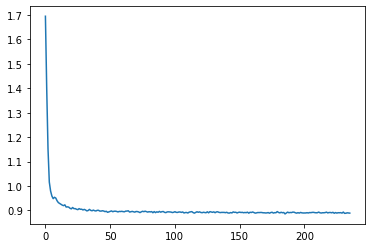

In [112]:
# out = {}
# loss = {}
# repulsion_strength = [0, 1.0,2.0,3.0,4.0,5.0,10.0,20.0,50.0,100.0]
# for i in np.arange(10):
model, target_index, losses  =  train_gnumap(new_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GCN', patience=50, epochs=500, lr=5e-2, wd=1e-5,
                                    min_dist=0.01, name_file="1", subsampling=25000,
                                    spread = 0.01, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = False)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

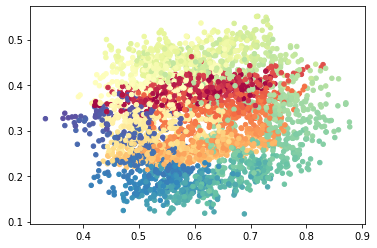

In [113]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [114]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.1333)

0.22579254149086106

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=3.7463, time=0.0387
Epoch=001, loss=3.7391, time=0.0365
Epoch=002, loss=3.7462, time=0.0347
Epoch=003, loss=3.7249, time=0.0363
Epoch=004, loss=3.7072, time=0.0370
Epoch=005, loss=3.6141, time=0.0503
Epoch=006, loss=3.6236, time=0.0410
Epoch=007, loss=3.6391, time=0.0477
Epoch=008, loss=3.6102, time=0.0582
Epoch=009, loss=3.5933, time=0.0495
Epoch=010, loss=3.6028, time=0.0524
Epoch=011, loss=3.5957, time=0.0550
Epoch=012, loss=3.5410, time=0.0408
Epoch=013, loss=3.5099, time=0.0358
Epoch=014, loss=3.5343, time=0.0371
Epoch=015, loss=3.5248, time=0.0420
Epoch=016, loss=3.4775, time=0.0521
Epoch=017, loss=3.4238, time=0.0458
Epoch=018, loss=3.4243, time=0.0354
Epoch=019, loss=3.3936, time=0.0358
Epoch=020, loss=3.3867, time=0.0366
Epoch=021, loss=3.4223, time=0.0424
Epoch=022, loss=3.3756, time=0.0412
Epoch=023, loss=3.4026, time=0.0423
Epoch=024, loss=3.3590, time=0.0403
Epoch=025, loss=3.3007, time=0.0393

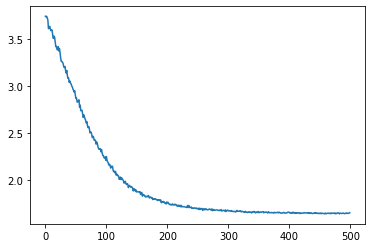

In [107]:
# out = {}
# loss = {}
# repulsion_strength = [0, 1.0,2.0,3.0,4.0,5.0,10.0,20.0,50.0,100.0]
# for i in np.arange(10):
model, target_index, losses  =  train_gnumap(diff_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GCN', patience=50, epochs=500, lr=1e-3, wd=1e-5,
                                    min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = False)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

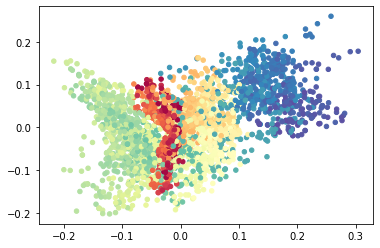

In [110]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [111]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.1574)

0.4165122784389764

Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=1.1402, time=0.0461
Epoch=001, loss=1.1068, time=0.0571
Epoch=002, loss=1.0829, time=0.0371
Epoch=003, loss=1.0512, time=0.0364
Epoch=004, loss=1.0364, time=0.0352
Epoch=005, loss=1.0003, time=0.0424
Epoch=006, loss=0.9875, time=0.0347
Epoch=007, loss=0.9624, time=0.0335
Epoch=008, loss=0.9529, time=0.0322
Epoch=009, loss=0.9338, time=0.0308
Epoch=010, loss=0.9213, time=0.0333
Epoch=011, loss=0.9117, time=0.0405
Epoch=012, loss=0.9063, time=0.0311
Epoch=013, loss=0.9022, time=0.0347
Epoch=014, loss=0.8946, time=0.0357
Epoch=015, loss=0.8902, time=0.0368
Epoch=016, loss=0.8882, time=0.0364
Epoch=017, loss=0.8862, time=0.0371
Epoch=018, loss=0.8840, time=0.0312
Epoch=019, loss=0.8837, time=0.0333
Epoch=020, loss=0.8795, time=0.0328
Epoch=021, loss=0.8785, time=0.0345
Epoch=022, loss=0.8797, time=0.0395
Epoch=023, loss=0.8788, time=0.0406
Epoch=024, loss=0.8808, time=0.0348
Epoch=025, loss=0.8768, time=0.0367

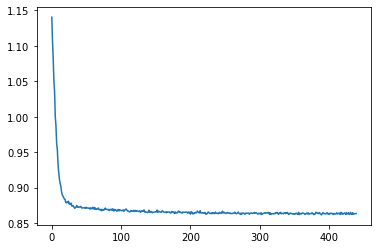

In [145]:
model, target_index, losses  =  train_gnumap(new_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN',  must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'normalize', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

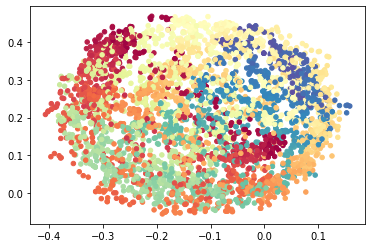

In [146]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [147]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.2032)

0.25176469352679637

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=2.6740, time=0.0530
Epoch=001, loss=2.5467, time=0.0331
Epoch=002, loss=2.4246, time=0.0292
Epoch=003, loss=2.3531, time=0.0341
Epoch=004, loss=2.2336, time=0.0419
Epoch=005, loss=2.1618, time=0.0482
Epoch=006, loss=2.0941, time=0.0327
Epoch=007, loss=1.9717, time=0.0284
Epoch=008, loss=1.9286, time=0.0278
Epoch=009, loss=1.8239, time=0.0296
Epoch=010, loss=1.7806, time=0.0290
Epoch=011, loss=1.7387, time=0.0352
Epoch=012, loss=1.6968, time=0.0345
Epoch=013, loss=1.6690, time=0.0361
Epoch=014, loss=1.6520, time=0.0389
Epoch=015, loss=1.6408, time=0.0340
Epoch=016, loss=1.6198, time=0.0377
Epoch=017, loss=1.6141, time=0.0364
Epoch=018, loss=1.6125, time=0.0383
Epoch=019, loss=1.6069, time=0.0313
Epoch=020, loss=1.6072, time=0.0331
Epoch=021, loss=1.6067, time=0.0297
Epoch=022, loss=1.6025, time=0.0309
Epoch=023, loss=1.5981, time=0.0307
Epoch=024, loss=1.6030, time=0.0302
Epoch=025, loss=1.6001, time=0.0299

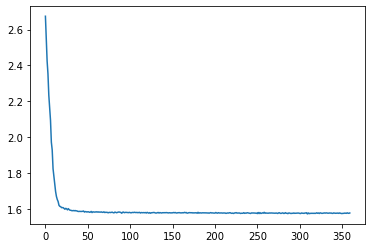

In [148]:
model, target_index, losses  =  train_gnumap(diff_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN',  must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'normalize', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

tensor(0.2261)

0.14551290012799228

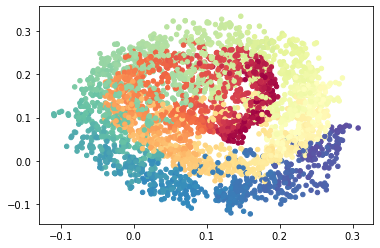

In [149]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=2.7059, time=0.0399
Epoch=001, loss=2.6242, time=0.0279
Epoch=002, loss=2.5661, time=0.0299
Epoch=003, loss=2.5507, time=0.0315
Epoch=004, loss=2.4988, time=0.0325
Epoch=005, loss=2.4517, time=0.0319
Epoch=006, loss=2.4406, time=0.0350
Epoch=007, loss=2.4004, time=0.0358
Epoch=008, loss=2.3714, time=0.0275
Epoch=009, loss=2.3492, time=0.0302
Epoch=010, loss=2.2782, time=0.0282
Epoch=011, loss=2.2288, time=0.0287
Epoch=012, loss=2.2201, time=0.0310
Epoch=013, loss=2.1797, time=0.0341
Epoch=014, loss=2.1683, time=0.0354
Epoch=015, loss=2.0962, time=0.0378
Epoch=016, loss=2.0781, time=0.0367
Epoch=017, loss=1.9764, time=0.0295
Epoch=018, loss=1.9648, time=0.0317
Epoch=019, loss=1.9134, time=0.0330
Epoch=020, loss=1.8254, time=0.0303
Epoch=021, loss=1.8148, time=0.0319
Epoch=022, loss=1.7343, time=0.0291
Epoch=023, loss=1.7047, time=0.0329
Epoch=024, loss=1.6503, time=0.0351
Epoch=025, loss=1.6071, time=0.0647

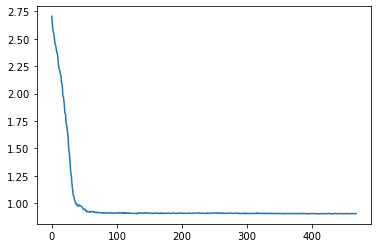

In [150]:
model, target_index, losses  =  train_gnumap(new_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN', must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'col_uniform', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

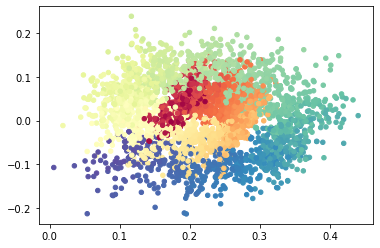

In [151]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [152]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.1458)

0.19966402761689978

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=7.0451, time=0.0458
Epoch=001, loss=6.8967, time=0.0378
Epoch=002, loss=6.6739, time=0.0307
Epoch=003, loss=6.5386, time=0.0373
Epoch=004, loss=6.4169, time=0.0323
Epoch=005, loss=6.2683, time=0.0352
Epoch=006, loss=6.1180, time=0.0332
Epoch=007, loss=6.1793, time=0.0300
Epoch=008, loss=6.0658, time=0.0339
Epoch=009, loss=5.9700, time=0.0415
Epoch=010, loss=5.8894, time=0.0369
Epoch=011, loss=5.7783, time=0.0323
Epoch=012, loss=5.6982, time=0.0281
Epoch=013, loss=5.5772, time=0.0312
Epoch=014, loss=5.5173, time=0.0282
Epoch=015, loss=5.3721, time=0.0296
Epoch=016, loss=5.2968, time=0.0344
Epoch=017, loss=5.1671, time=0.0405
Epoch=018, loss=5.0152, time=0.0395
Epoch=019, loss=4.8658, time=0.0369
Epoch=020, loss=4.8217, time=0.0375
Epoch=021, loss=4.6746, time=0.0329
Epoch=022, loss=4.4699, time=0.0345
Epoch=023, loss=4.4190, time=0.0331
Epoch=024, loss=4.1143, time=0.0340
Epoch=025, loss=3.9859, time=0.0303

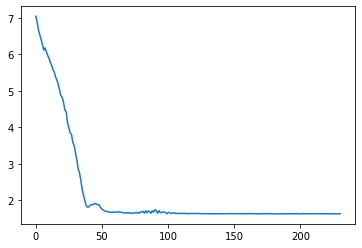

In [153]:
model, target_index, losses  =  train_gnumap(diff_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN', must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'col_uniform', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

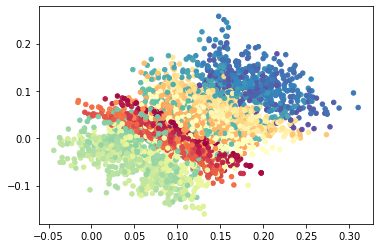

In [154]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [155]:
from evaluation_metric import *
neighbor_kept_ratio_eval(diff_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.1525)

0.4276111635981103

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=2.3506, time=0.0488
Epoch=001, loss=2.3371, time=0.0317
Epoch=002, loss=2.2774, time=0.0302
Epoch=003, loss=2.2119, time=0.0304
Epoch=004, loss=2.0818, time=0.0285
Epoch=005, loss=2.0906, time=0.0346
Epoch=006, loss=1.9714, time=0.0428
Epoch=007, loss=1.9942, time=0.0343
Epoch=008, loss=1.8854, time=0.0300
Epoch=009, loss=1.8171, time=0.0307
Epoch=010, loss=1.8205, time=0.0304
Epoch=011, loss=1.7423, time=0.0302
Epoch=012, loss=1.6999, time=0.0360
Epoch=013, loss=1.6119, time=0.0323
Epoch=014, loss=1.4477, time=0.0353
Epoch=015, loss=1.4547, time=0.0383
Epoch=016, loss=1.4195, time=0.0374
Epoch=017, loss=1.3503, time=0.0303
Epoch=018, loss=1.2714, time=0.0306
Epoch=019, loss=1.2838, time=0.0306
Epoch=020, loss=1.1880, time=0.0306
Epoch=021, loss=1.2295, time=0.0318
Epoch=022, loss=1.1445, time=0.0333
Epoch=023, loss=1.0811, time=0.0484
Epoch=024, loss=1.0576, time=0.0495
Epoch=025, loss=1.0617, time=0.0428

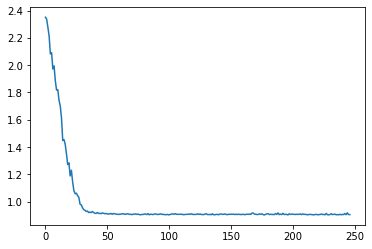

In [156]:
model, target_index, losses  =  train_gnumap(new_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN', must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'uniform', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

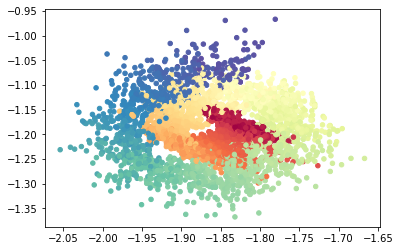

In [157]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [158]:
from evaluation_metric import *
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.1558)

0.18958477875962873

/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/Users/sowonjeong/Documents/GitHub/gnumap/notebooks/../../gnumap/umap_functions.py:161: RuntimeWarning: overflow encountered in multiply
  return 1.0 / (1.0 + a * x ** (2 * b))


Hyperparameters a = 5991743.780433192 and b = 1.9292367516734124
Epoch=000, loss=6.1996, time=0.0468
Epoch=001, loss=5.7467, time=0.0342
Epoch=002, loss=5.5857, time=0.0323
Epoch=003, loss=5.5143, time=0.0374
Epoch=004, loss=5.0044, time=0.0343
Epoch=005, loss=4.9329, time=0.0356
Epoch=006, loss=4.8574, time=0.0367
Epoch=007, loss=4.6939, time=0.0332
Epoch=008, loss=4.4912, time=0.0352
Epoch=009, loss=4.4188, time=0.0335
Epoch=010, loss=4.3016, time=0.0369
Epoch=011, loss=3.9245, time=0.0333
Epoch=012, loss=3.7586, time=0.0343
Epoch=013, loss=3.7254, time=0.0447
Epoch=014, loss=3.3927, time=0.0651
Epoch=015, loss=3.1050, time=0.0465
Epoch=016, loss=3.3539, time=0.0606
Epoch=017, loss=2.5935, time=0.0445
Epoch=018, loss=2.5805, time=0.0431
Epoch=019, loss=2.6762, time=0.0421
Epoch=020, loss=2.5455, time=0.0480
Epoch=021, loss=2.4066, time=0.0398
Epoch=022, loss=2.2061, time=0.0372
Epoch=023, loss=2.1054, time=0.0382
Epoch=024, loss=2.0059, time=0.0354
Epoch=025, loss=1.9180, time=0.0387

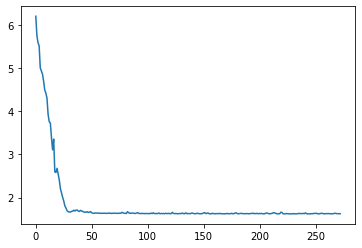

In [159]:
model, target_index, losses  =  train_gnumap(diff_data, 32, 2, n_layers=2, target=None,
                                    model_type = 'GNN', must_propagate= [True, True],
                                    patience=50, epochs=500, lr=1e-2, wd=1e-5,
                                    norm = 'uniform', min_dist=1e-2, name_file="1", subsampling=25000,
                                    spread = 1e-2, repulsion_strength=5.0,
                                    device=None, verbose = False, normalized = True)
out = model(new_data.x.float(), new_data.edge_index)
plt.plot(losses)

tensor(0.1159)

0.20268375941432482

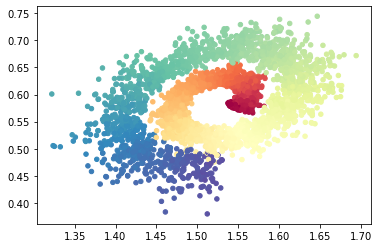

In [160]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

=== train GRACE model ===
Epoch=000, loss=8.6585
Epoch=001, loss=8.8687
Epoch=002, loss=8.9557
Epoch=003, loss=9.2174
Epoch=004, loss=8.9568
Epoch=005, loss=9.2224
Epoch=006, loss=8.6283
Epoch=007, loss=8.5594
Epoch=008, loss=8.8252
Epoch=009, loss=8.8512
Epoch=010, loss=8.9204
Epoch=011, loss=8.6343
Epoch=012, loss=8.8546
Epoch=013, loss=8.5603
Epoch=014, loss=8.6287
Epoch=015, loss=8.9363
Epoch=016, loss=8.6142
Epoch=017, loss=8.9136
Epoch=018, loss=8.5639
Epoch=019, loss=8.8856
Epoch=020, loss=8.5949
Epoch=021, loss=8.6026
Epoch=022, loss=8.8249
Epoch=023, loss=8.5806
Epoch=024, loss=9.1408
Epoch=025, loss=8.8368
Epoch=026, loss=8.9086
Epoch=027, loss=8.8260
Epoch=028, loss=8.8845
Epoch=029, loss=9.3293
Epoch=030, loss=8.5720
Epoch=031, loss=8.5604
Epoch=032, loss=8.5600
Epoch=033, loss=8.8835
Epoch=034, loss=8.8258
Epoch=035, loss=8.5639
Epoch=036, loss=8.5670
Epoch=037, loss=9.2337
Epoch=038, loss=8.8100
Epoch=039, loss=8.8235
Epoch=040, loss=9.2550
Epoch=041, loss=8.5485
Epoch=04

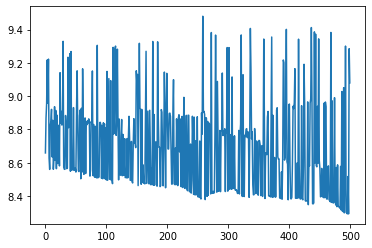

In [169]:
model, loss = train_grace(diff_data, 32, 2, n_layers=2, tau=0.1,
                epochs=500, wd=1e-5, lr=1e-3, fmr=0.2, edr =0.2,
                proj="nonlinear-hid", name_file="test", device=None)
plt.plot(loss)
out = model.get_embedding(new_data)

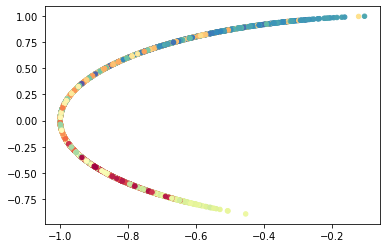

In [170]:
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [171]:
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.0413)

0.099469058020871

=== train CCa model model ===
Epoch=000, loss=-0.3146
Epoch=001, loss=-1.0074
Epoch=002, loss=-0.9436
Epoch=003, loss=-1.1729
Epoch=004, loss=-0.9271
Epoch=005, loss=-0.7642
Epoch=006, loss=0.0220
Epoch=007, loss=-0.3730
Epoch=008, loss=-1.2200
Epoch=009, loss=-1.2713
Epoch=010, loss=-1.0115
Epoch=011, loss=-0.8627
Epoch=012, loss=-0.5704
Epoch=013, loss=-0.6183
Epoch=014, loss=-0.5979
Epoch=015, loss=-1.3979
Epoch=016, loss=-1.4105
Epoch=017, loss=-0.5488
Epoch=018, loss=-1.1517
Epoch=019, loss=-0.6132
Epoch=020, loss=-0.6564
Epoch=021, loss=-1.1302
Epoch=022, loss=-1.0871
Epoch=023, loss=-1.4439
Epoch=024, loss=-1.6309
Epoch=025, loss=-1.5376
Epoch=026, loss=-0.7250
Epoch=027, loss=-0.6963
Epoch=028, loss=-1.5245
Epoch=029, loss=-1.5180
Epoch=030, loss=-1.5184
Epoch=031, loss=-1.5515
Epoch=032, loss=-0.8775
Epoch=033, loss=-0.0141
Epoch=034, loss=-1.2089
Epoch=035, loss=-1.5425
Epoch=036, loss=-1.5349
Epoch=037, loss=-1.0259
Epoch=038, loss=-1.5948
Epoch=039, loss=-0.5948
Epoch=040, 

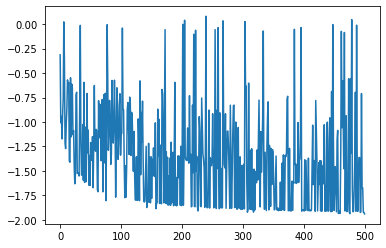

In [172]:
model,loss = train_cca_ssg(new_data,  32, 2, lambd=1e-5,
                n_layers=2, epochs=500, lr=1e-3,
                fmr=0.2, edr =0.5, name_file="test",
                device=None)
plt.plot(loss)

not converging**

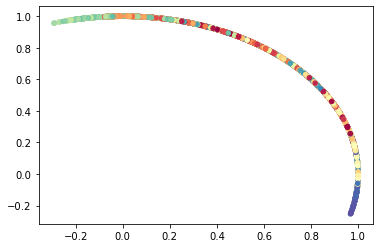

In [173]:
out = model.get_embedding(new_data)
plt.scatter(out.detach().numpy()[:,0],out.detach().numpy()[:,1], c = t, cmap="Spectral", s = 20)

In [174]:
neighbor_kept_ratio_eval(new_data, out.detach().numpy(), n_neighbors=5) # local structure 
_, _, corr_sp, _ = spearman_correlation_eval(perfect_embeddings, out.detach().numpy(), n_points = 1000, type = 'euclidean') # global structure
corr_sp

tensor(0.0444)

0.11575215359570554